# Ma 17

In [381]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import constants
import sympy as sym
from sympy import sympify
import scipy.stats as stats

In [382]:
#Prints a value with its error in scientific notation up to its 2 decimal
def print_scientific(value,error):
    """
    value (float) : the value
    error (float) : the error
    
    Returns:
        (string) : formatted string with the value an error
    """
    base10_error=int(np.floor(np.log10(error)))
    base10_value=int(np.floor(np.log10(np.abs(value))))
    digits=int(base10_value-base10_error+1)
    base=10**base10_value
    string=f"({value/base:.{digits}f} ± {error/base:.{digits}f})·10^{base10_value}"
    return string

In [383]:
def compute_error(expression, variables, values, errors):
    """
    expression (string) : expression you used to compute the value
    variables  (list of strings) : list of variables that are in the expression in string form
    values     (list of float)   : list of values that go in the expression
    errors     (list of float)   : list of errors for each value
    
    Returns: (result, uncertainty) : tuple with the desired value and its uncertainty
    
    !! ATTENTION: Length variables = length values = length errors
    
    An example: 
    >   expression="x**2+y"
    >   var=["x","y"]; values=[2,1]; errors=[4,2]
    >   compute_error(expression, var, values, errors)
    """
    #Make variables and expression symbolic
    expression=sym.sympify(expression)
    variables=sym.symbols(variables)
    
    #To store coefficients
    coefficients=[]
    
    for index,variable in enumerate(
        variables):
        dexpression=sym.diff(expression, variable) #Differentiates expression
        coefficient=dexpression.subs(list(zip(variables, values))) #substitution
        coefficients.append(errors[index]*np.float64(coefficient)) #multiply coefficient times error
    
    uncertainty=np.sqrt(np.sum(np.array(coefficients)**2))
    result=np.float64(expression.subs(list(zip(variables, values))))

    return result,uncertainty
    

### Computing the width in air

In [384]:
#All units in SI
K_R=1664

<AxesSubplot:xlabel='Time (s)'>

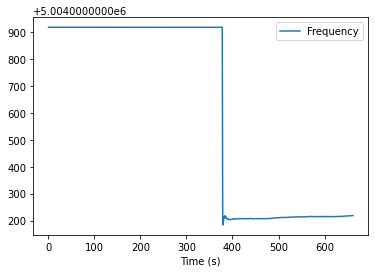

In [385]:
#Load dataframe
df=df=pd.read_csv(f"data/eigen_air.csv", sep=";")
frequency=np.array(df["Frequency"])
time=np.array(df["Time (s)"])
df.plot(x="Time (s)", y="Frequency")

In [386]:
#Take from 0 to 300s
freq_air=frequency[time<=300]
eigenfreq_air=np.mean(freq_air)
stdfreq_air=np.std(freq_air)

In [387]:
print(f"The eigenfrequency in air is "+print_scientific(eigenfreq_air,stdfreq_air)+" Hz")

The eigenfrequency in air is (5.004918717 ± 0.000000083)·10^6 Hz


In [388]:
expression=f"{K_R}/f_0"
var=["f_0"]; values=[eigenfreq_air]; errors=[stdfreq_air]
d_q, stdd_q=compute_error(expression,var,values,errors)

In [389]:
print(f"The thickness is "+print_scientific(d_q,stdd_q)+" m")

The thickness is (3.324729319 ± 0.000000055)·10^-4 m


Around a tenth of a milimiter, looks good.

### Computing frequency difference

There are two ways we can do this. First just roughly computing the difference. And then secondly taking into account the apparent frequency drift.

<AxesSubplot:xlabel='Time (s)'>

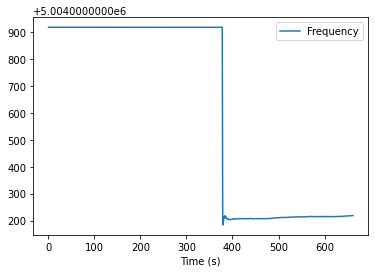

In [390]:
#Show graph
df=df=pd.read_csv(f"data/eigen_air.csv", sep=";")
df.plot(x="Time (s)", y="Frequency")

#### Rough eye approximation

In [391]:
#Take from 400 to end
freq_eth=frequency[time>=400]
stdfreq_eth=np.std(freq_eth)
eigenfreq_eth=np.mean(freq_eth)

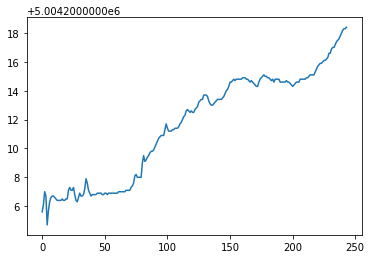

In [392]:
plt.plot(freq_eth)

In [393]:
print(f"The eigenfrequency in ethanol is "+print_scientific(eigenfreq_air,stdfreq_air)+" Hz")

The eigenfrequency in ethanol is (5.004918717 ± 0.000000083)·10^6 Hz


In [394]:
delta_freq=eigenfreq_air-eigenfreq_eth
stddelta_freq=np.sqrt(stdfreq_eth**2+stdfreq_air**2)
print(f"The delta f in ethanol is "+print_scientific(delta_freq,stddelta_freq)+" Hz")

The delta f in ethanol is (7.071 ± 0.037)·10^2 Hz


#### Linear approximation

In [395]:
#Take from 400 to end
freq_eth=frequency[time>=400]
time_eth=time[time>=400]

In [396]:
linregression= stats.linregress(time_eth, freq_eth)

In [397]:
print(f"We obtain a regression with slope "+print_scientific(linregression.slope,linregression.stderr)+" s^-2")
print(f"and an intercept of "+print_scientific(linregression.slope,linregression.intercept_stderr)+" Hz")
print(f"With a p-value of {linregression.pvalue:.2E}<<0.05, for the null hypothesis: the slope is 0")
print(f"Finally the r^2 score is {linregression.rvalue:.2f}")

We obtain a regression with slope (4.740 ± 0.081)·10^-2 s^-2
and an intercept of (5 ± 44)·10^-2 Hz
With a p-value of 1.61E-144<<0.05, for the null hypothesis: the slope is 0
Finally the r^2 score is 0.97


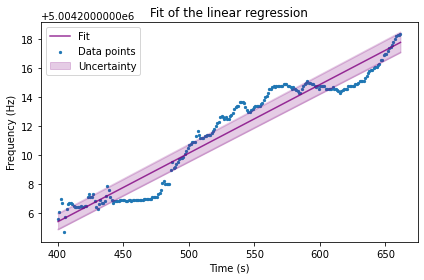

In [398]:
#Draw the graph with uncertainty in the slope
X=time_eth; Y=time_eth*linregression.slope+linregression.intercept;
uncertainty_regression=np.sqrt((X*linregression.stderr)**2+linregression.intercept_stderr**2)
plt.scatter(time_eth, freq_eth,s=5, label="Data points")
plt.plot(X,Y, color="purple", alpha=0.8, label="Fit")
plt.plot(X,uncertainty_regression+Y, color="purple", alpha=0.2)
plt.plot(X,Y-uncertainty_regression, color="purple", alpha=0.2)
plt.fill_between(X, Y+uncertainty_regression, Y-uncertainty_regression,
                color="purple", alpha=0.2, label="Uncertainty")
plt.legend()
plt.xlabel("Time (s)"); plt.ylabel("Frequency (Hz)")
plt.title("Fit of the linear regression")
plt.tight_layout()

The high r^2 score gives validity to the idea that there is a linear relation between frequency and time while the low p-value tells us that if that is the case, then the slope is certainly not 0. That is, there is frequency drift.

Following this we can compute the expected frequency when the crystal is submerged. Let's say at the minimum of the graph.

In [399]:
min_time=np.array(df["Time (s)"])[frequency==np.min(frequency)]
freq_ethregression=linregression.slope*min_time[0]+linregression.intercept
stdfreq_ethregression=np.sqrt((min_time*linregression.stderr)**2+linregression.intercept_stderr**2)

In [400]:
delta_freqregression=eigenfreq_air-freq_ethregression
stddelta_freqregression=np.sqrt(stdfreq_ethregression**2+stdfreq_air**2)[0]
print(f"The delta f in ethanol with the regression is "+print_scientific(delta_freqregression,stddelta_freqregression)+" Hz")

The delta f in ethanol with the regression is (7.1433 ± 0.0054)·10^2 Hz


Taking into account the drift has not changed much in this case.

#### Quick check for the air

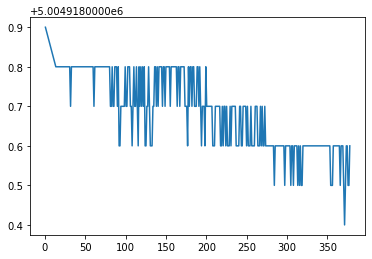

In [401]:
#Take from 400 to end
freq_air=frequency[time<min_time]
time_air=time[time<min_time]
plt.plot(time_air,freq_air)

In [402]:
linregression= stats.linregress(time_air, freq_air)

In [403]:
print(f"We obtain a regression with slope "+print_scientific(linregression.slope,linregression.stderr)+" s^-2")
print(f"and an intercept of "+print_scientific(linregression.slope,linregression.intercept_stderr)+" Hz")
print(f"With a p-value of {linregression.pvalue:.2E}<<0.05, for the null hypothesis: the slope is 0")
print(f"Finally the r^2 score is {linregression.rvalue:.2f}")

We obtain a regression with slope (-7.39 ± 0.28)·10^-4 s^-2
and an intercept of (-7 ± 62)·10^-4 Hz
With a p-value of 1.55E-84<<0.05, for the null hypothesis: the slope is 0
Finally the r^2 score is -0.82


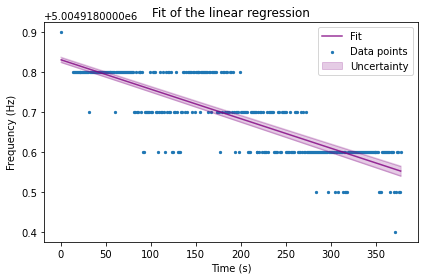

In [404]:
#Draw the graph with uncertainty in the slope
X=time_air; Y=time_air*linregression.slope+linregression.intercept;
uncertainty_regression=np.sqrt((X*linregression.stderr)**2+linregression.intercept_stderr**2)
plt.scatter(time_air, freq_air,s=5, label="Data points")
plt.plot(X,Y, color="purple", alpha=0.8, label="Fit")
plt.plot(X,uncertainty_regression+Y, color="purple", alpha=0.2)
plt.plot(X,Y-uncertainty_regression, color="purple", alpha=0.2)
plt.fill_between(X, Y+uncertainty_regression, Y-uncertainty_regression,
                color="purple", alpha=0.2, label="Uncertainty")
plt.legend()
plt.xlabel("Time (s)"); plt.ylabel("Frequency (Hz)")
plt.title("Fit of the linear regression")
plt.tight_layout()

We can see that there is indeed a drift. The frequency decreases (why? maybe debris settles? oscillomiter gives less energy?) but it is so subtle that it happens in the viccinity of the sensibility of our instruments.

Indeed the slope is 100 times smaller than the one of the ethanol and thus negligible.

In [406]:
min_time=np.array(df["Time (s)"])[frequency==np.min(frequency)]
freq_airregression=linregression.slope*min_time[0]+linregression.intercept
stdfreq_airregression=np.sqrt((min_time*linregression.stderr)**2+linregression.intercept_stderr**2)

In [407]:
delta_freqregression=freq_airregression-freq_ethregression
stddelta_freqregression=np.sqrt(stdfreq_ethregression**2+stdfreq_airregression**2)[0]
print(f"The delta f in ethanol with the regression is "+print_scientific(delta_freqregression,stddelta_freqregression)+" Hz")

The delta f in ethanol with the regression is (7.1416 ± 0.0053)·10^2 Hz


Adding this drift correction yields a measurement within the range of the first one.

### Comparison with the computed value

In [431]:
mu_q=2.947e11*(constants.gram)/(constants.centi)
rho_q=2.648*(constants.gram)*(constants.centi)**(-3)
stdrho_q=0.001*(constants.gram)*(constants.centi)**(-3)
stdmu_q=0.001e11*(constants.gram)/(constants.centi)
mu_L=1116.5e-6; rho_L=786.8

In [432]:
expression=f"-f_0**(3/2)*(rho_L*mu_L/({np.pi}*mu_q*rho_q))**(1/2)"
var=["f_0", "rho_L", "mu_L", "rho_q", "mu_q"]; 
values=[eigenfreq_air, rho_L, mu_L, rho_q, mu_q]; 
errors=[stdfreq_air, rho_L*0.002, mu_L*0.002, stdrho_q, stdmu_q]
deltafreq_theory, stddeltafreq_theory=compute_error(expression, var, values, errors)

In [433]:
print("The theoretical delta f is "+print_scientific(deltafreq_theory, stddeltafreq_theory)+" Hz")

The theoretical delta f is (-6.7024 ± 0.0096)·10^2 Hz


In [430]:
print(f"The delta f in ethanol with the regression is "+print_scientific(-delta_freqregression,stddelta_freqregression)+" Hz")

The delta f in ethanol with the regression is (-7.1416 ± 0.0053)·10^2 Hz


However the precission of the instruments is only of 1 Hz therefore it is more reasonable to say that the empirical frequency difference is 714\pm 1 Hz. Even with this more generous error margin the experimental value is clearly out of range. However we must remember that we are dealing with a first order approximation 